In [1]:
import numpy as np
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from bertopic import BERTopic
from bertopic.representation import OpenAI
import openai
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from spacy.lang.de.stop_words import STOP_WORDS



In [3]:
# Reading and preprocessing JSON's

with open("booking_reviews_678_varlen_clean.json", "r", encoding="utf-8") as f:
    gt_json = json.load(f)
    print(str(type(gt_json)))
    gt_df = pd.DataFrame(gt_json['tickets'])

with open("results_booking_reviews_678_varlen_clean.json", "r", encoding="utf-8") as f:
    pred_json = json.load(f)

<class 'dict'>


In [5]:
print("Original amount of gtound truth tickets is " + str(len(gt_df)))

Original amount of gtound truth tickets is 678


At first glance I would say that JSON with predictions already looks hallucinated, but I need to proof it somehow

# First approach: direct text matching

Down below are functions which are used further for direct text matching

In [7]:
def text_matches_search_phrase(text, search_phrase):
    words = search_phrase.split(' ')
    for word in words:
        word_found = text.find(word)
        if word_found == -1:
            return False
    return True

In [9]:
def text_matches_search_query(text, search_query):
    search_list = search_query.split('+')
    cleaned = [search_phrase.strip() for search_phrase in search_list]
    for search_phrase in cleaned:
        phrase_found = text_matches_search_phrase(text, search_phrase)
        if phrase_found:
            return True
    return False

In [11]:
def remove_duplicates(messages):
    seen = set()
    result = []
    for m in messages:
        if not m['message_text'] in seen:
            result.append(m)
            seen.add(m['message_text'])
    return result

In [13]:
#Unfolding JSON's
topics_list = pred_json["gemini-2.5-flash"]
messages = gt_json['tickets']


rows = [] # here are will contain info with distinct subtopics saving topic_id
all_examples = [] # and here distinct string examples saving both subtopic and topic_id
for topic_id, topic_group in enumerate(topics_list):  # upper level
    for subtopic in topic_group:  # subtopic list unfolding
        examples = subtopic["examples"]
        matching_messages = list(filter(lambda message: text_matches_search_query(message['message_text'], subtopic["search_query"]), messages))
        sentiment = subtopic["sentiment"]
        matching_sentiment = list(filter(lambda message: message['sentiment__filter'] == sentiment, matching_messages))
        row = {
            "topic_id": topic_id,
            "subtopic": subtopic["subtopic"],
            "search_query": subtopic["search_query"],
            "percent": subtopic["percent"],
            "sentiment": subtopic["sentiment"],
            "matching_messages": matching_messages,
            "matching_sentiment": matching_sentiment,
            "matching_messages_count": len(matching_messages),
            "matching_sentiment_count": len(matching_sentiment)
        }
        rows.append(row)
        for ex in examples:
            all_examples.append({
                "topic_id": topic_id,
                "subtopic": subtopic["subtopic"],
                "search_query": subtopic["search_query"],#.replace('+', ','),
                "sentiment_pred_topic": subtopic["sentiment"],
                "message_text_pred": ex
            })

In [15]:
topic_rows = {}
for row in rows: 
    topic_id = row['topic_id']
    # Здесь делаем так, чтобы при агрегации считывались уникальные тикеты по топикам, чтобы они не пересекались внутри каждого
    topic_row = topic_rows[topic_id] if topic_id in topic_rows else {
        'topic_id' : topic_id,
        'matching_messages' : [],
        'matching_sentiment' : []
    }
    topic_row['matching_messages'].extend(row['matching_messages'])
    topic_row['matching_sentiment'].extend(row['matching_sentiment'])
    topic_rows[topic_id] = topic_row

for topic_id in topic_rows:
    topic_row = topic_rows[topic_id]
    topic_row['matching_messages'] = remove_duplicates(topic_row['matching_messages'])
    topic_row['matching_sentiment'] = remove_duplicates(topic_row['matching_sentiment'])
    topic_row['matching_messages_count'] = len(topic_row['matching_messages'])
    topic_row['matching_sentiment_count'] = len(topic_row['matching_sentiment'])

In [17]:
# Marked up dataframe building
pred_df = pd.DataFrame(rows)
topic_df = pd.DataFrame(topic_rows.values())[["topic_id", "matching_messages_count", "matching_sentiment_count"]]

examples_df = pd.DataFrame(all_examples) # save this for further operations

In [19]:
topic_df['matching_sentiment_share'] = round((topic_df.matching_sentiment_count/topic_df.matching_messages_count),3)

In [21]:
topic_df

,topic_id,matching_messages_count,matching_sentiment_count,matching_sentiment_share
0,0,264,219,0.830
1,1,264,219,0.830
2,2,264,219,0.830
3,3,264,219,0.830
4,4,303,250,0.825


As it shown above, first 4 topics are identical in matches quantitatively. More than that, subtopics are repeating themselves in most cases

In [23]:
pred_df['subtopic'].value_counts()

subtopic
App Stability & Performance         5
Unexpected Charges & Pricing        4
Ease of Booking & Confirmation      4
Clear Cancellation Policy           4
Effective Customer Support          4
Interface & Navigation              4
Notifications & Advertising         4
Customer Support Issues             4
Property & Booking Discrepancies    4
Unexpected Charges & Fees           1
Unwanted Notifications & Ads        1
Booking Discrepancies               1
Slow Customer Support               1
Positive Booking Experience         1
Clear Policies & Communication      1
Rewards & Savings                   1
General App Usability               1
Name: count, dtype: int64

Here we see the confirmation that most of suptopics are not unique in the predictions

In [26]:
pred_df['matching_sentiment_share'] = round((pred_df.matching_sentiment_count/pred_df.matching_messages_count),3)

In [28]:
pred_df[['topic_id', 'subtopic', 'matching_messages_count', 'matching_sentiment_count', 'matching_sentiment_share']].drop_duplicates(subset=["subtopic", "matching_sentiment_share"])

,topic_id,subtopic,matching_messages_count,matching_sentiment_count,matching_sentiment_share
0,0,Unexpected Charges & Pricing,64,64,1.000
1,0,App Stability & Performance,101,40,0.396
2,0,Property & Booking Discrepancies,117,63,0.538
3,0,Customer Support Issues,28,28,1.000
4,0,Notifications & Advertising,33,33,1.000
5,0,Ease of Booking & Confirmation,102,102,1.000
6,0,Effective Customer Support,43,43,1.000
7,0,Clear Cancellation Policy,46,31,0.674
8,0,Interface & Navigation,112,87,0.777
36,4,Unexpected Charges & Fees,70,70,1.000


In [30]:
uniq_examples = examples_df['message_text_pred'].value_counts()

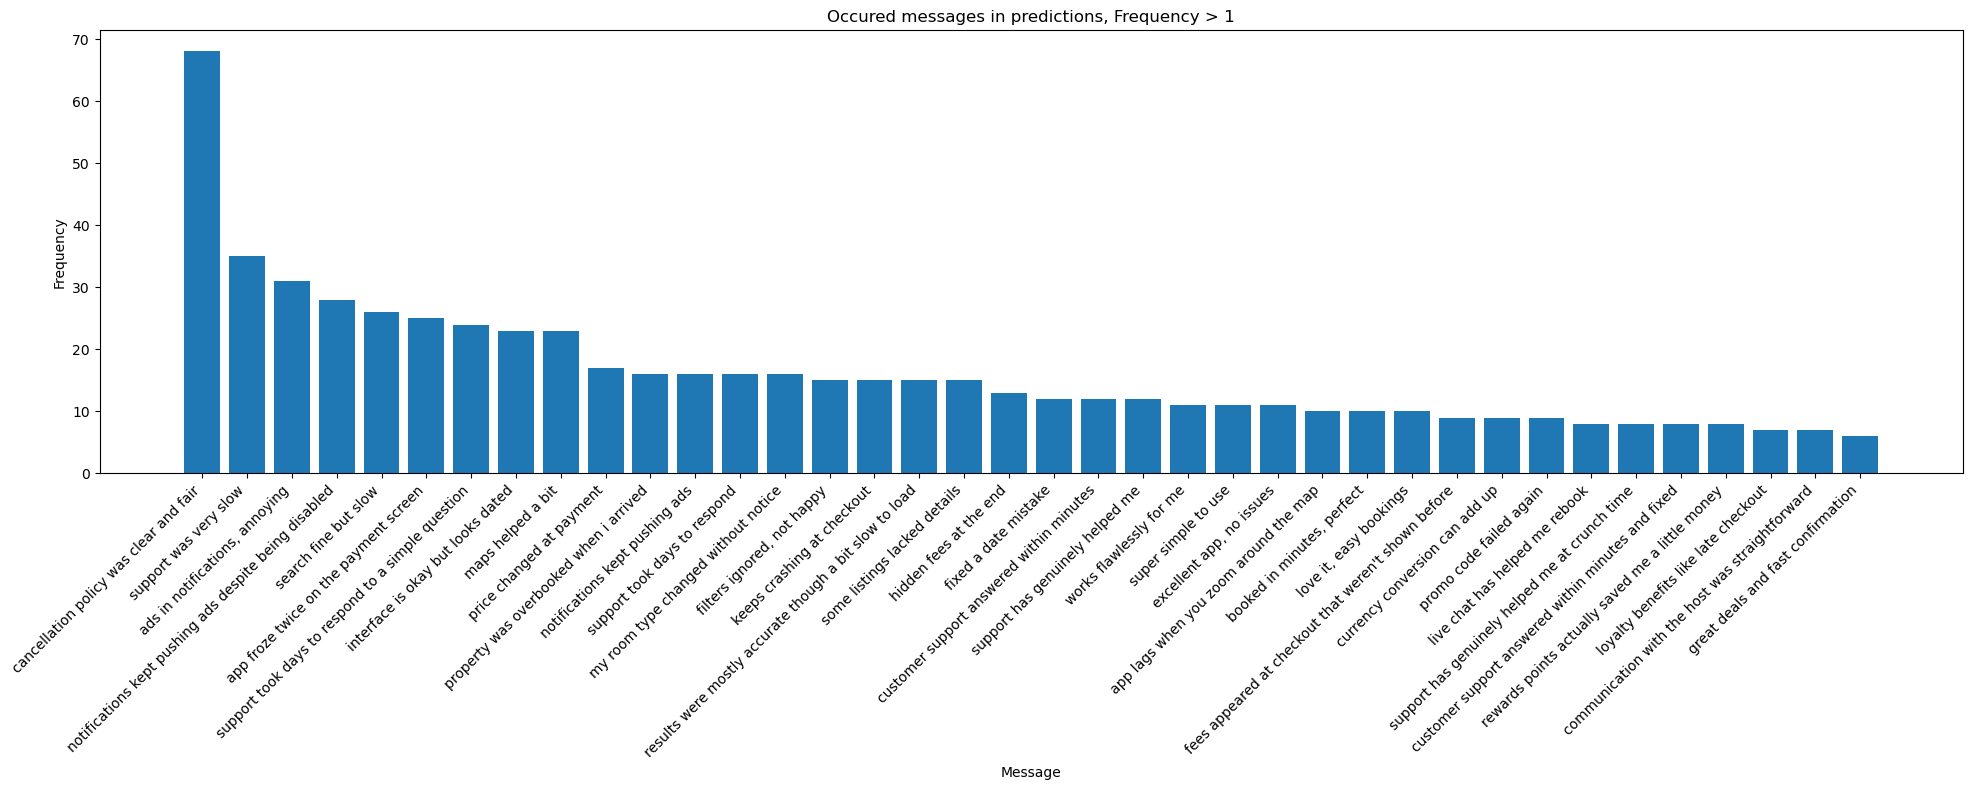

In [32]:
uniq_f = uniq_examples[uniq_examples > 5]

# Create the bar plot
plt.figure(figsize=(20, 8))
plt.bar(uniq_f.index.astype(str), uniq_f.values)
plt.xlabel('Message')
plt.ylabel('Frequency')
plt.title('Occured messages in predictions, Frequency > 1')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


These topics are clusters. We need to measure how good these clusters are. We can't measure strings, we should transfrom them into vectors (embeddings)

In [34]:
def evaluate_topic_clustering(examples_df, max_features=2000):


    #print("🔍 Data preparing...")

    # Drop duplicates and empty strings
    df = examples_df.dropna(subset=["message_text_pred", "topic_id"]).copy()
    df["message_text_pred"] = df["message_text_pred"].str.lower().str.strip()
    df = df.drop_duplicates(subset=["message_text_pred", "topic_id"])

    # Check message quantity
    print(f"✅ There are {len(df)} of unique textes left for evaluation of ({df['topic_id'].nunique()} themes)")

    if df["topic_id"].nunique() < 2:
        print("⚠️ Not enough topics for clusterisation (need ≥ 2)")
        return None

    # === 1. Text vectorising ===
    print("🔠 Text vectorising TF-IDF...")
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df["message_text_pred"])

    # === 2. Clusterisation metrics ===
    print("📏 Clusterisation metrics calculation...")
    try:
        silhouette = silhouette_score(X, df["topic_id"])
        ch_score = calinski_harabasz_score(X.toarray(), df["topic_id"])
        db_score = davies_bouldin_score(X.toarray(), df["topic_id"])
    except Exception as e:
        print(f"⚠️ ERROR metrics calculation: {e}")
        return None

    print("\n📊 Clusterisation calculation is over:")
    print(f"   • Silhouette Score:        {silhouette:.3f}  (→ closer to 1 is better)")
    print(f"   • Calinski-Harabasz Score: {ch_score:.2f}  (→ the bigger the better)")
    print(f"   • Davies-Bouldin Index:    {db_score:.3f}  (→ closer to zero is better)")

    # === 3. Semantic analysis of topics ===
    print("\n🧩 Key words analysis in topics...")
    count_vec = CountVectorizer(stop_words='english')
    X_counts = count_vec.fit_transform(df["message_text_pred"])
    words = count_vec.get_feature_names_out()

    topic_keywords = (
        pd.DataFrame(X_counts.toarray(), columns=words)
        .groupby(df["topic_id"])
        .sum()
        .apply(lambda x: x.sort_values(ascending=False).head(10).index.tolist(), axis=1)
        .reset_index()
        .rename(columns={0: "top_words"})
    )
    
    print("\n📋 Top-words examples in topics:")
    for _, row in topic_keywords.head(5).iterrows():
        print(f"   • Topic {row['topic_id']}: {', '.join(row['top_words'])}")

    print("\n✅ Clusterisation evaluation is done.")
    return {
        "silhouette": silhouette,
        "calinski_harabasz": ch_score,
        "davies_bouldin": db_score,
        "topic_keywords": topic_keywords
    }


In [36]:
topic_eval = evaluate_topic_clustering(examples_df)

topic_keywords = topic_eval["topic_keywords"]
display(topic_keywords)

✅ There are 221 of unique textes left for evaluation of (5 themes)
🔠 Text vectorising TF-IDF...
📏 Clusterisation metrics calculation...

📊 Clusterisation calculation is over:
   • Silhouette Score:        -0.022  (→ closer to 1 is better)
   • Calinski-Harabasz Score: 0.17  (→ the bigger the better)
   • Davies-Bouldin Index:    14.308  (→ closer to zero is better)

🧩 Key words analysis in topics...

📋 Top-words examples in topics:
   • Topic 0.0: fees, support, appeared, checkout, finding, customer, confirmation, minutes, answered, helped
   • Topic 1.0: support, helped, checkout, twice, pricing, fees, code, fair, confirmation, conversion

✅ Clusterisation evaluation is done.


,topic_id,top_words
0,0.0,"[fees, support, appeared, checkout, finding, c..."
1,1.0,"[support, helped, checkout, twice, pricing, fe..."


As we can see - 4 of 5 topics have collapsed, it can be easily checked by reproducing same code without drop duplicates - first 4 of them will be identical

In [44]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
#import umap.umap_ as UMAP
#import umap
import umap.umap_ as umap


In [64]:
def visualize_topics_with_umap_tsne(examples_df, max_features=2000, sample_size=1000, random_state=42):
    """
    Topic visualisation by UMAP, t-SNE и DBSCAN.
    examples_df: DataFrame with columns ['topic_id', 'message_text_pred']
    """

    print("🔍 Data preparation...")
    df = examples_df.dropna(subset=["message_text_pred", "topic_id"]).copy()
    df["message_text_pred"] = df["message_text_pred"].str.lower().str.strip()
    df = df.drop_duplicates(subset=["message_text_pred", "topic_id"])

    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=random_state)
        print(f"📉 Выборка уменьшена до {sample_size} строк для скорости")

    # === TF-IDF ===
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(df["message_text_pred"])

    # === UMAP ===
    print("🌀 UMAP projection...")
    reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_state)
    embedding_umap = reducer_umap.fit_transform(X)

    # === t-SNE ===
    print("🎨 t-SNE projection ")
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state, learning_rate='auto', init='random')
    embedding_tsne = tsne.fit_transform(X.toarray())

    # === DBSCAN ===
    print("🔍 Launch DBSCAN...")
    dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
    db_labels = dbscan.fit_predict(X)

    # === Making DataFrame with embeddings ===
    vis_df = pd.DataFrame({
        "topic_id": df["topic_id"].values,
        "text": df["message_text_pred"].values,
        "dbscan_label": db_labels,
        "umap_x": embedding_umap[:, 0],
        "umap_y": embedding_umap[:, 1],
        "tsne_x": embedding_tsne[:, 0],
        "tsne_y": embedding_tsne[:, 1]
    })

    # === Visualisations ===
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=vis_df, x="umap_x", y="umap_y", hue="topic_id", palette="tab10", s=40, alpha=0.8
    )
    plt.title("UMAP: topic_id distribution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=vis_df, x="tsne_x", y="tsne_y", hue="topic_id", palette="tab10", s=40, alpha=0.8
    )
    plt.title("t-SNE: topic_id distribution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # === DBSCAN visualization ===
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=vis_df, x="umap_x", y="umap_y", hue="dbscan_label", palette="tab20", s=40, alpha=0.8
    )
    plt.title("UMAP + DBSCAN: natural hole clusters")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # === Статистика DBSCAN ===
    cluster_counts = pd.Series(db_labels).value_counts()
    n_clusters = len(cluster_counts[cluster_counts.index != -1])
    print(f"📈 DBSCAN made {n_clusters} clusters (+ {cluster_counts.get(-1, 0)} noise points).")

    return vis_df


🔍 Data preparation...
🌀 UMAP projection...
🎨 t-SNE projection 
🔍 Launch DBSCAN...


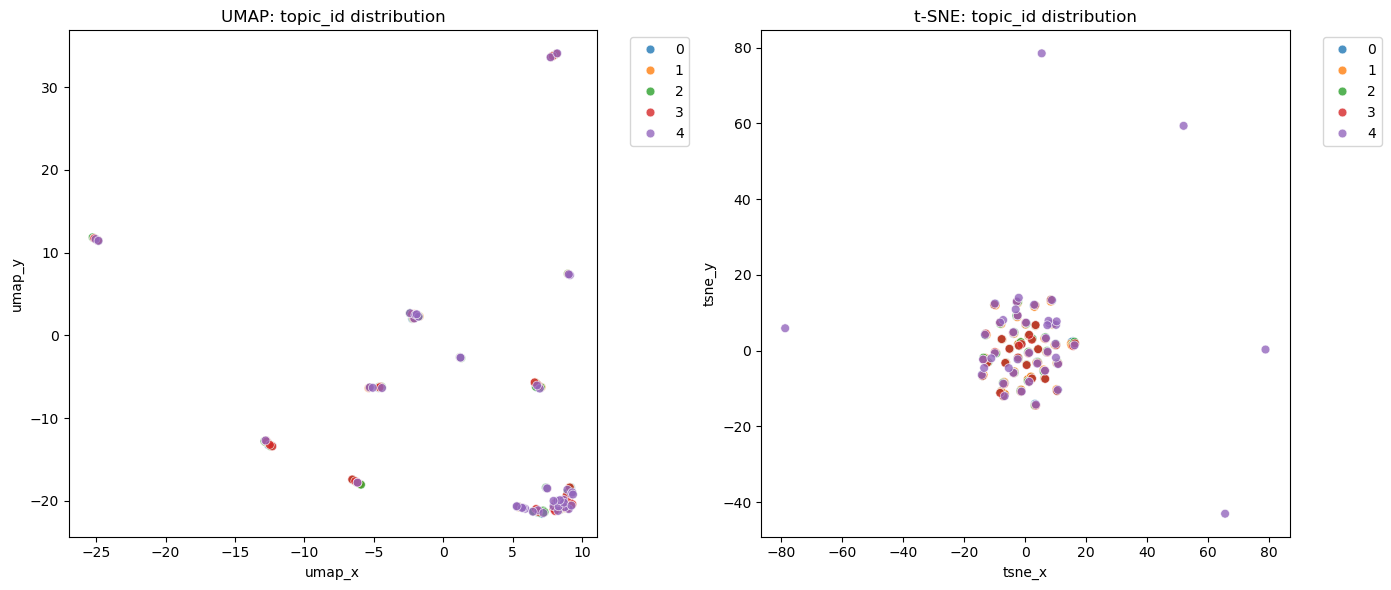

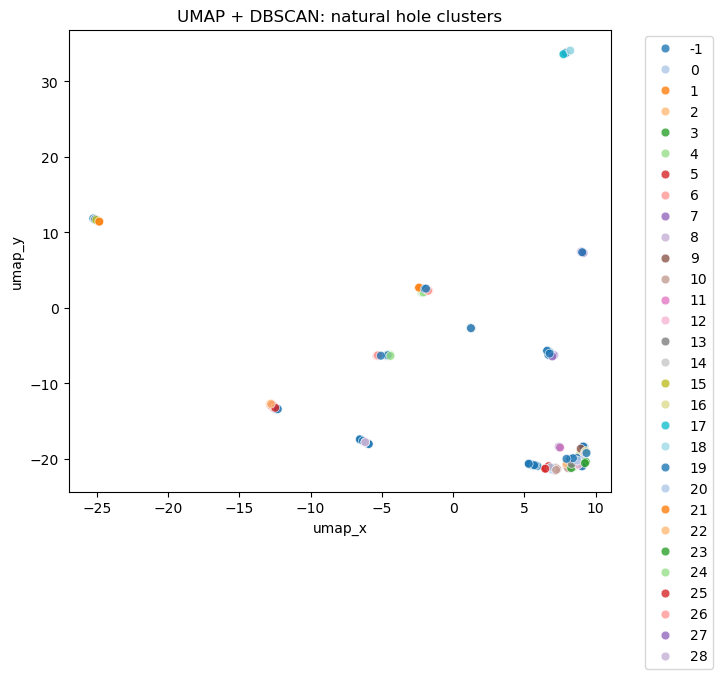

📈 DBSCAN made 29 clusters (+ 69 noise points).


In [66]:
vis_df = visualize_topics_with_umap_tsne(examples_df, sample_size=1000)

In [ ]:
Clusters are confirming that topics are overlapping and most of them are the same

# Total vibe-code experiment

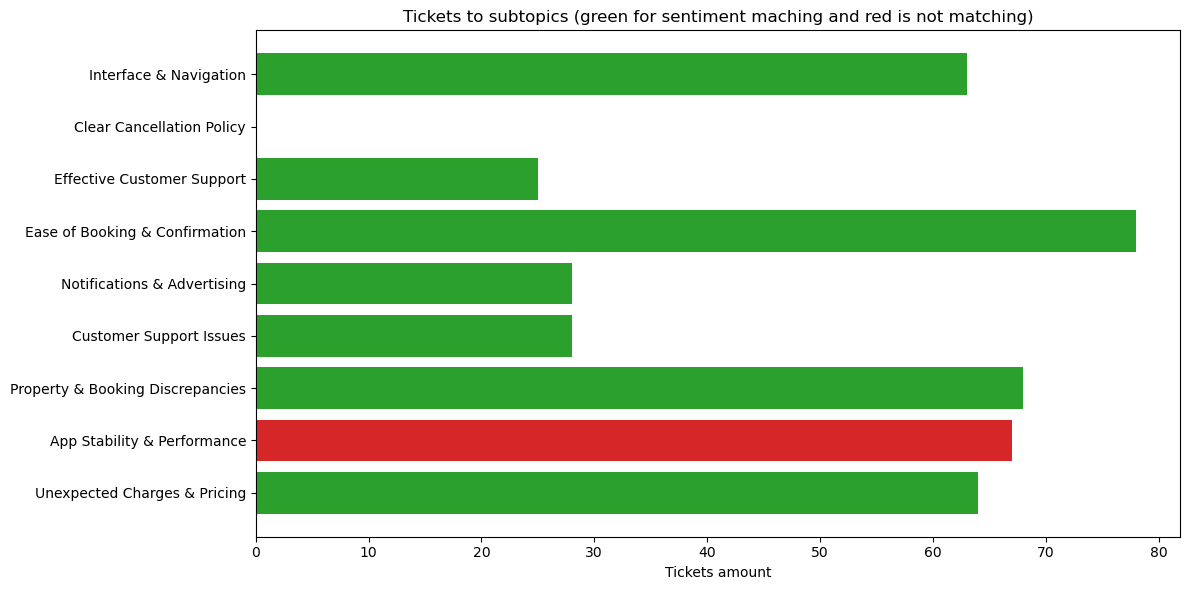

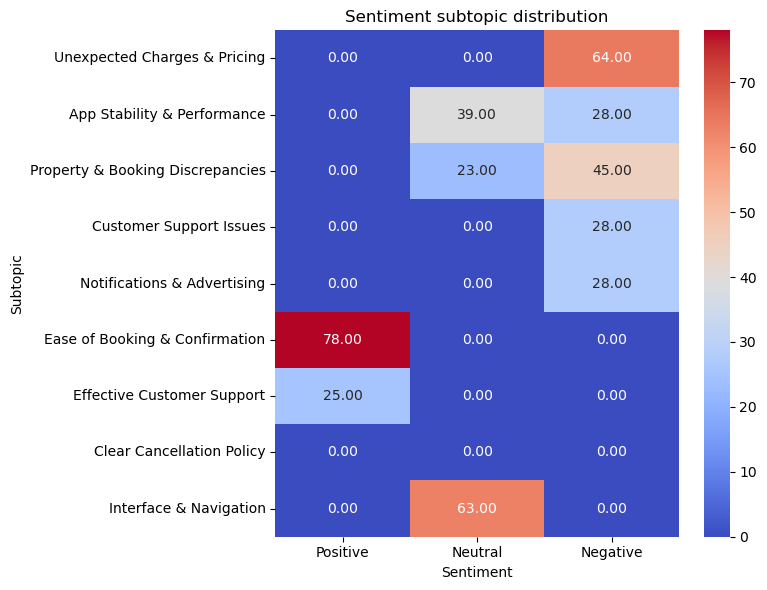

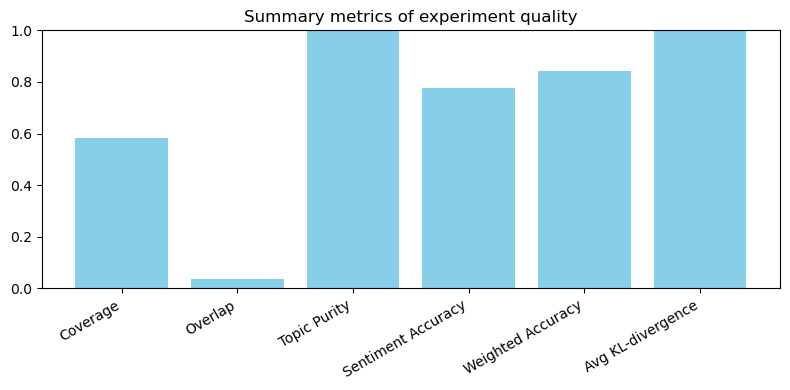


=== Summary metrics ===
Coverage            : 58.26%
Overlap             : 3.83%
Topic Purity        : 106.58%
Sentiment Accuracy  : 77.78%
Weighted Accuracy   : 84.09%
Avg KL-divergence   : 248.40%


In [53]:
from collections import Counter, defaultdict
import math

# === Загрузка данных ===
with open("booking_reviews_678_varlen_clean.json", "r") as f:
    tickets = json.load(f)["tickets"]

with open("results_booking_reviews_678_varlen_clean.json", "r") as f:
    topics = json.load(f)["gemini-2.5-flash"][0]

# === Утилиты ===
def normalize_text(s: str):
    return s.lower().strip()

def match_ticket_to_query(text: str, query: str) -> bool:
    text = normalize_text(text)
    for q in query.split("+"):
        if q.strip().lower() in text:
            return True
    return False

def kl_divergence(p, q):
    eps = 1e-10
    return sum(p[k]*math.log((p[k]+eps)/(q[k]+eps)) for k in p)

# === Base calculation ===
subtopic_results = []
all_ticket_ids = set()
ticket_to_subtopics = defaultdict(list)

for sub in topics:
    matched_tickets = [
        (i, t) for i, t in enumerate(tickets)
        if match_ticket_to_query(t["message_text"], sub["search_query"])
    ]
    for i, _ in matched_tickets:
        ticket_to_subtopics[i].append(sub["subtopic"])
    all_ticket_ids.update([i for i, _ in matched_tickets])
    sentiments = [t["sentiment__filter"] for _, t in matched_tickets]
    sentiment_counts = Counter(sentiments)
    n = len(matched_tickets)
    if n > 0:
        dist = {s: c/n for s, c in sentiment_counts.items()}
        expected = {"Positive":0, "Neutral":0, "Negative":0}
        expected[sub["sentiment"]] = 1
        kl = kl_divergence({k: dist.get(k,0) for k in expected}, expected)
    else:
        dist, kl = {}, None

    majority = max(sentiment_counts, key=sentiment_counts.get) if sentiments else None
    correct = int(majority == sub["sentiment"])

    subtopic_results.append({
        "subtopic": sub["subtopic"],
        "declared_sentiment": sub["sentiment"],
        "ticket_count": n,
        "sentiment_distribution": dict(sentiment_counts),
        "majority_sentiment": majority,
        "sentiment_match": bool(correct),
        "kl_divergence": kl
    })

# === Metrics for subtopics ===
coverage = len(all_ticket_ids) / len(tickets)
overlap = sum(len(v)>1 for v in ticket_to_subtopics.values()) / len(tickets)
purity = sum(len(v) for v in ticket_to_subtopics.values()) / len(ticket_to_subtopics)
sentiment_accuracy = sum(r["sentiment_match"] for r in subtopic_results) / len(subtopic_results)
weighted_accuracy = sum(r["sentiment_match"]*r["ticket_count"] for r in subtopic_results) / \
                    sum(r["ticket_count"] for r in subtopic_results)
kl_mean = sum(r["kl_divergence"] for r in subtopic_results if r["kl_divergence"] is not None) / \
          sum(1 for r in subtopic_results if r["kl_divergence"] is not None)

# === Visualisation ===
df = pd.DataFrame(subtopic_results)

# 1️⃣ Bar chart: tickets amount + sentiment matching
plt.figure(figsize=(12,6))
colors = df["sentiment_match"].map({True: "tab:green", False: "tab:red"})
plt.barh(df["subtopic"], df["ticket_count"], color=colors)
plt.xlabel("Tickets amount")
plt.title("Tickets to subtopics (green for sentiment maching and red is not matching)")
plt.tight_layout()
plt.show()

# 2️⃣ Heatmap: sentiment subtopic distribution
heatmap_data = pd.DataFrame([
    {
        "subtopic": r["subtopic"],
        **{s: r["sentiment_distribution"].get(s,0) for s in ["Positive","Neutral","Negative"]}
    } for r in subtopic_results
]).set_index("subtopic")

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sentiment subtopic distribution")
plt.xlabel("Sentiment")
plt.ylabel("Subtopic")
plt.tight_layout()
plt.show()

# 3️⃣ Summary metrics
summary_metrics = {
    "Coverage": coverage,
    "Overlap": overlap,
    "Topic Purity": purity,
    "Sentiment Accuracy": sentiment_accuracy,
    "Weighted Accuracy": weighted_accuracy,
    "Avg KL-divergence": kl_mean
}

plt.figure(figsize=(8,4))
plt.bar(summary_metrics.keys(), summary_metrics.values(), color="skyblue")
plt.xticks(rotation=30, ha="right")
plt.ylim(0,1)
plt.title("Summary metrics of experiment quality")
plt.tight_layout()
plt.show()

# === Текстовый вывод ===
print("\n=== Summary metrics ===")
for k,v in summary_metrics.items():
    print(f"{k:20}: {v:.2%}")


Conclusion: topic dividing itself is unsatisfactory, subtopic sentiment markup mostly good except for "App Stability and Performance", sentiment markup for topics is doubtful due to it's poor division

Also, I see that I definetely need to improve my EDA skills, not to be afraid of complex data structures, learn more advanced ML and DL, learn how to implement OpenAI correctly and use it freely

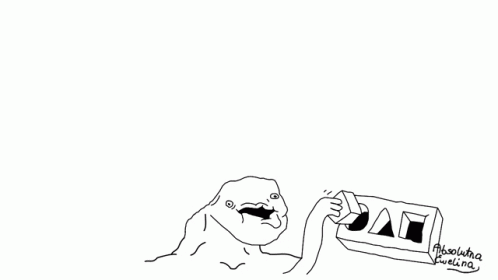

In [61]:
from IPython import display
display.Image("https://media.tenor.com/7k8RrC3BsgIAAAAC/wojak-blocks.gif")